In [1935]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

In [1936]:
Target_cell_number = 2e5
well_size = 125e-6
t_end = 60*60*200
t = np.geomspace(1e-10, t_end, 100)
t_span = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
sigma = well_size*N_A/Target_cell_number

Ainit = 1e-4
D = 1e-13
k2 = 4*D/tumour_cell_surface_area

In [1937]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

In [1938]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def simulate_model(times, parameters):
     
    solution = np.zeros_like(times)
    rtot = parameters[0]
    rtot = 10**rtot
    kon = parameters[1]
    kon = 10**kon
    koff = parameters[2]
    koff = 10**koff

    
             
    z = solve_ivp(model_S_monospecific, t_span, z0, method='Radau', 
                    t_eval=t, args=(Ainit, rtot, kon, k2, koff))
             
    A1 = z.y[0]
    A2 = z.y[1]
    bound_ab = (A1 + 2*A2)
    solution =bound_ab/np.max(bound_ab)
     
    return solution

def simulate_model_stst(A0s, parameters):

    solution = np.ones_like(A0s)

    rtot = parameters[0]
    rtot = 10**rtot
    kon = parameters[1]
    kon = 10**kon
    koff = parameters[2]
    koff = 10**koff

    for i, Ainit in enumerate(A0s):
        A1 = fsolve(A1_steady_state, [0], args=(Ainit, kon, koff, k2, rtot))
        A2 = A2_steady_state(A1, k2, koff, rtot)
        bound_ab = (A1 + 2*A2)
        solution[i] = bound_ab
    
    return solution

class model(pints.ForwardModel):

    def n_outputs(self):
         return super().n_outputs()
    
    def n_parameters(self):
        return 3
    
    def simulate(self, parameters, times):
        return simulate_model(times, parameters)


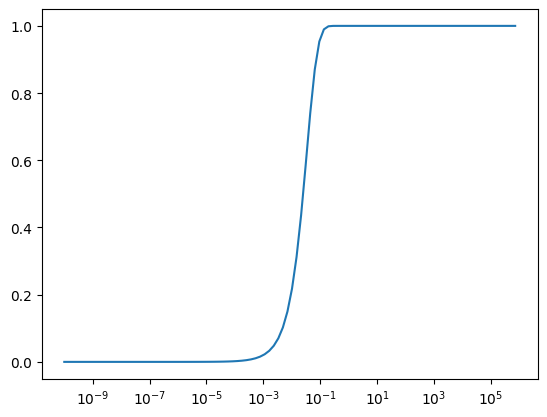

In [1939]:
A0s = np.geomspace(1e-12, 1e-4, 50)
rtot = 5
kon = 5
koff = -4

parameters = [rtot, kon, koff]

sol = simulate_model(t, parameters)
plt.semilogx(t, sol)

Text(0.5, 0, 'Antibody concentration')

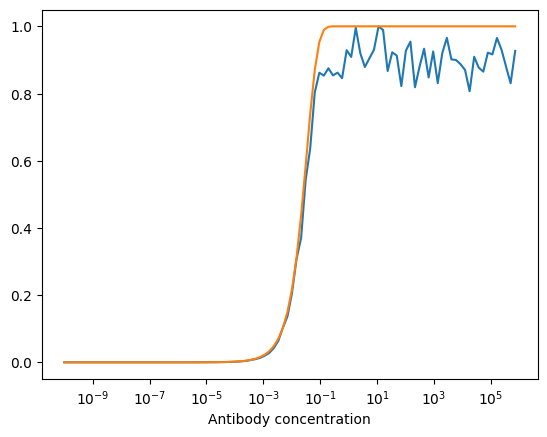

In [1940]:
noise = 0.05
values = sol*1e5*np.random.normal(1, noise, sol.shape)
values = values/np.max(values)
#sol = sol/np.max(sol)
plt.semilogx(t, values)
plt.semilogx(t, sol)
plt.xlabel(r'Antibody concentration')

In [1941]:
mod = model()
problem = pints.SingleOutputProblem(mod, t, values)

In [1942]:
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters += [noise]
print(parameters)

[5, 5, -4, 0.05]


In [1943]:
log_prior = pints.UniformLogPrior(
    [4, 4, -5, 0.01],
    [6, 6, -2, 0.15]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [1944]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [1945]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(5000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0.5       0         0.5        0:00.0
2     12     0         0.333     0         0.667      0:00.1
3     16     0         0.25      0         0.5        0:00.1
20    84     0.238     0.19      0.286     0.333      0:00.3
40    164    0.146     0.171     0.22      0.195122   0:00.7
60    244    0.115     0.164     0.18      0.147541   0:01.0
80    324    0.0988    0.123     0.16      0.148      0:01.4
100   404    0.0792    0.099     0.129     0.139      0:01.7
120   484    0.0826    0.0909    0.107438  0.132      0:02.1
140   564    0.0851    0.0993    0.113     0.121      0:02.4
160   644    0.0994    0.106     0.0994    0.106      0:02.8
180   724    0.0994    0.105     0.0994    0.11       0:03.2
Initial phase completed.
200   804    0.104     0.

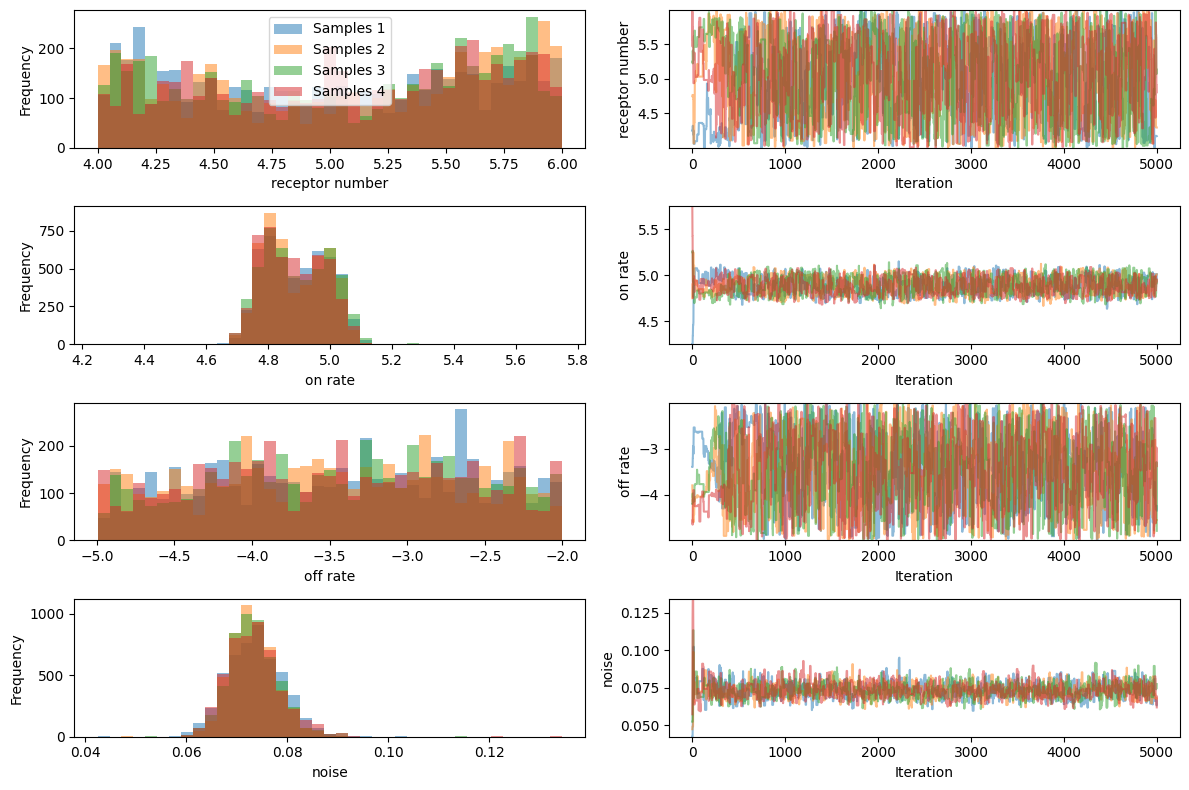

In [1946]:
import pints.plot
pints.plot.trace(chains, parameter_names=['receptor number', 'on rate', 'off rate', 'noise'])
plt.show()

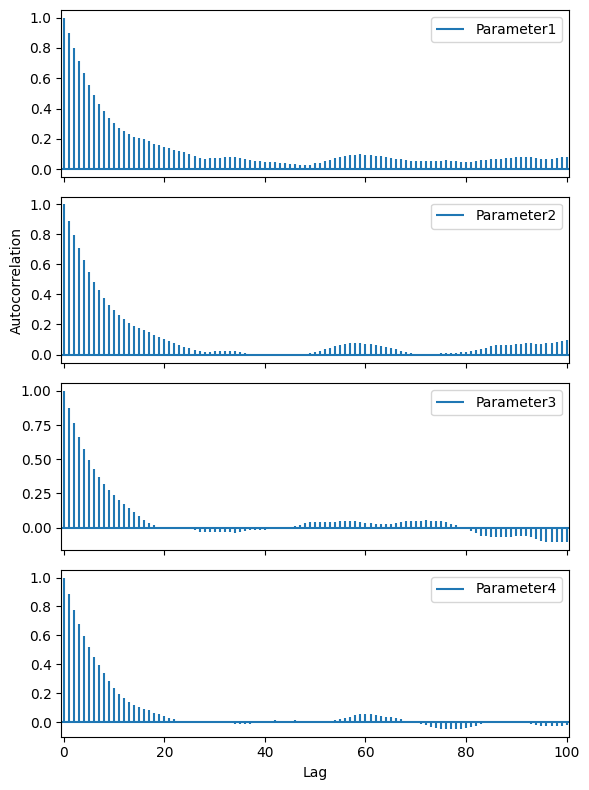

In [1947]:
chain = chains[0]
chain = chain[750:]
pints.plot.autocorrelation(chain)
plt.show()

In [1948]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['receptor number', 'on rate', 'off rate', 'noise'])
print(results)


param            mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
---------------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
receptor number  5.05    0.62    4.05    4.47   5.10   5.62   5.96     1.01    668.47   13.98
on rate          4.89    0.10    4.73    4.80   4.88   4.98   5.07     1.00    796.93   16.67
off rate         -3.46   0.83    -4.90   -4.13  -3.43  -2.76  -2.08    1.01    608.54   12.73
noise            0.07    0.01    0.06    0.07   0.07   0.08   0.08     1.00    1152.00  24.10


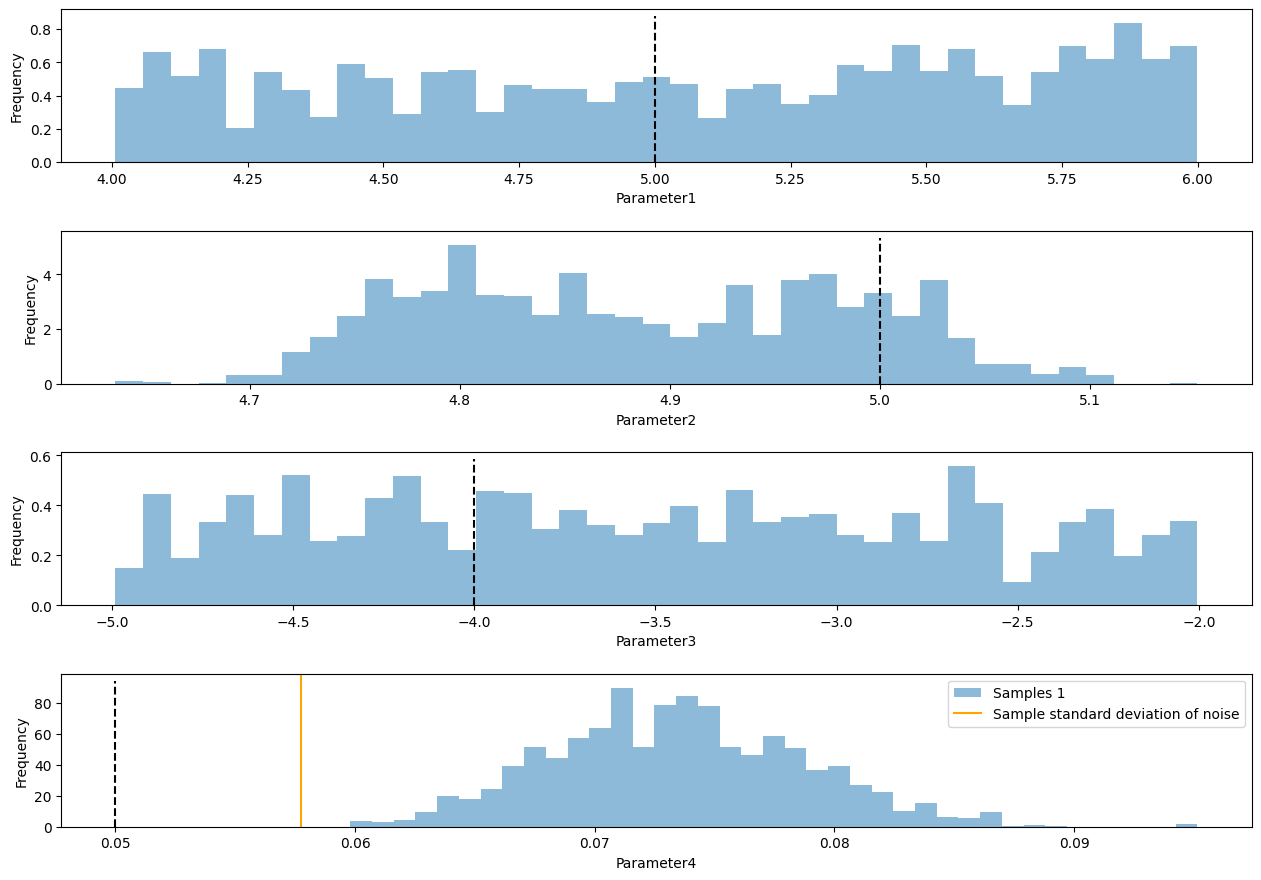

In [1949]:
fig, axes = pints.plot.histogram([chain], ref_parameters=parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - sol)
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

In [1950]:
chain = chain[::10]

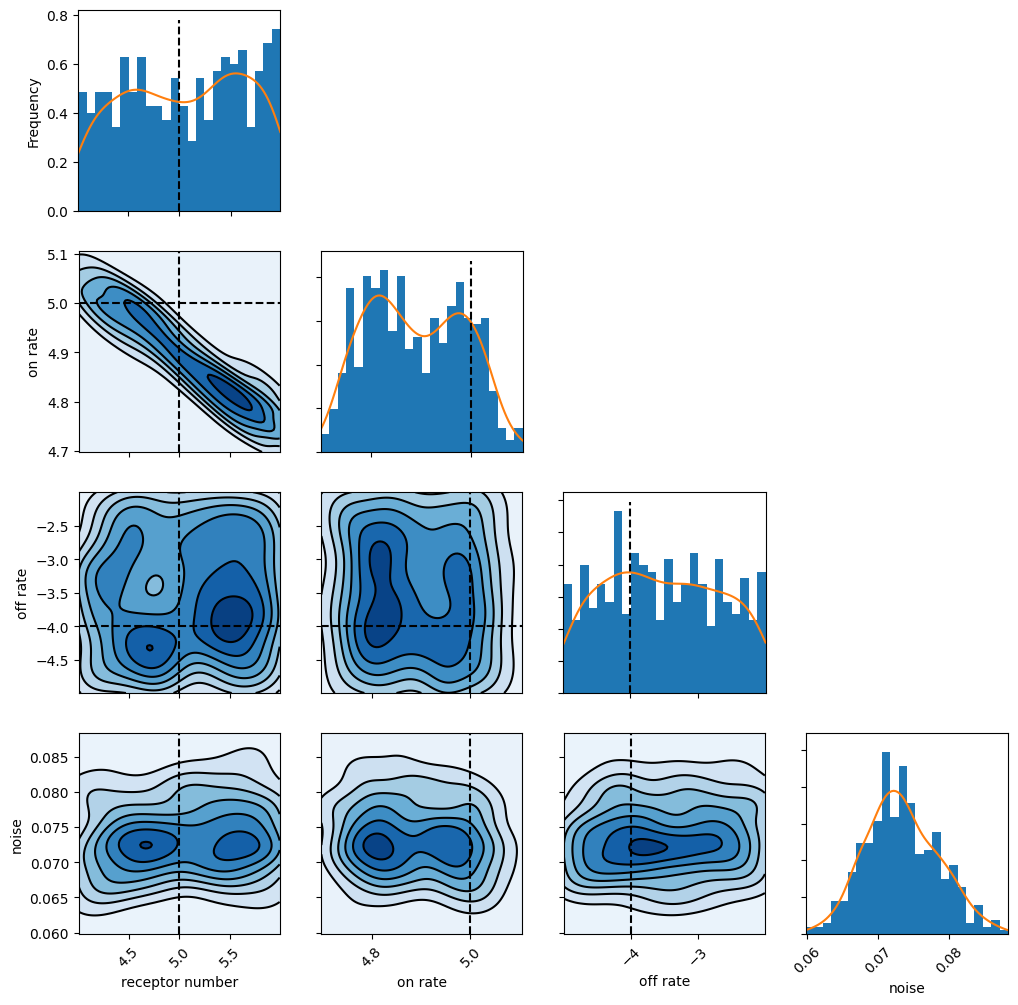

In [1951]:
pints.plot.pairwise(chain, kde=True, ref_parameters=parameters, parameter_names=['receptor number', 'on rate', 'off rate', 'noise'])
plt.show()

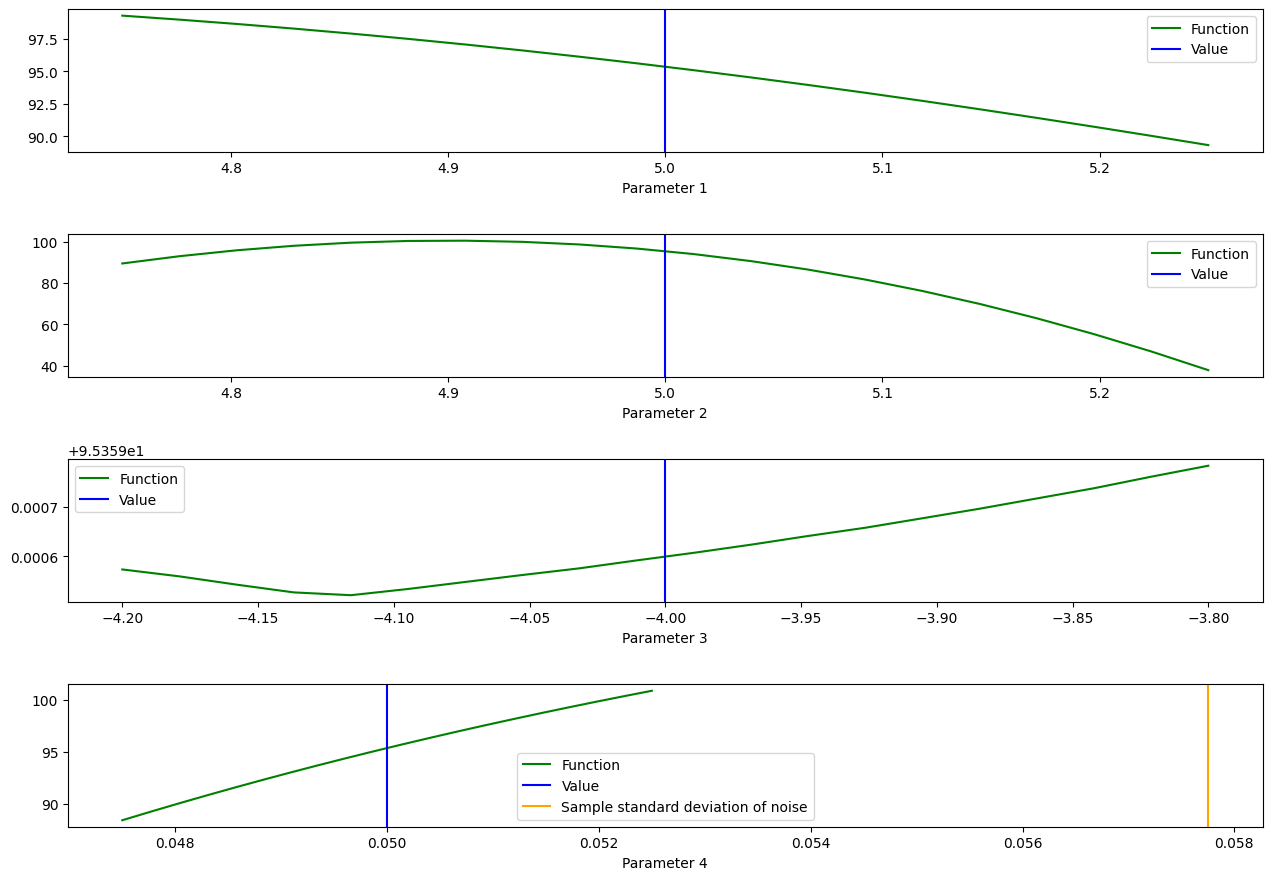

In [1952]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

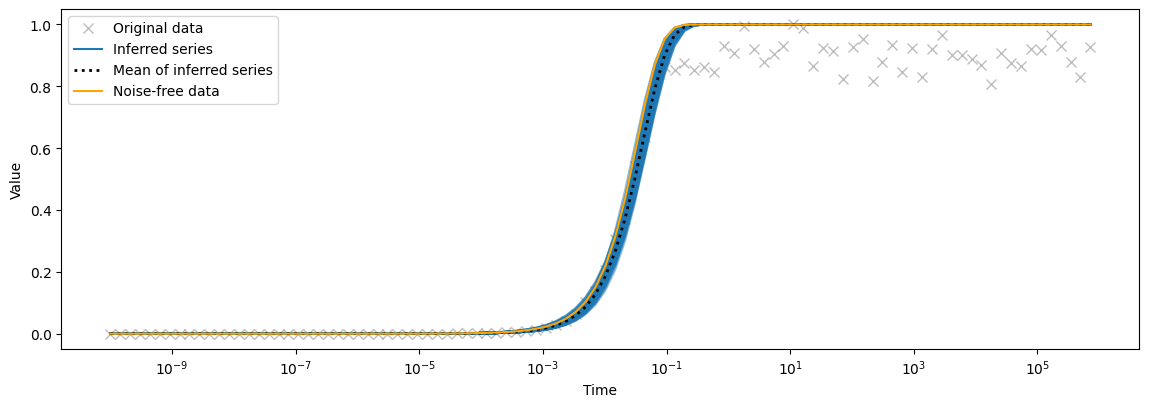

In [1953]:
fig, axes = pints.plot.series(chain, problem)

fig.set_size_inches(12,4.5)
plt.plot(t, sol, c='orange', label='Noise-free data')
plt.legend()
plt.xscale('log')
plt.show()